In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feather

In [2]:
DIR ="../input/riiid-test-answer-prediction/"
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")
train = pd.read_feather("../input/riid-train/train.feather")

# train
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before  seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

- content_type_id = 0なら、questions.csvと結合できる, content_type_id = 1なら、lectures.csvと結合できる

In [3]:
train.shape

(101230332, 10)

In [4]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,4294967295,None
1,1,56943,115,5716,0,2,2,1,37000,False
2,2,118363,115,128,0,0,0,1,55000,False
3,3,131167,115,7860,0,3,0,1,19000,False
4,4,137965,115,7922,0,4,1,1,11000,False


In [5]:
len(train.user_id.unique())

393656

In [6]:
train.user_id.unique()[:10]

array([  115,   124,  2746,  5382,  8623,  8701, 12741, 13134, 24418,
       24600], dtype=uint32)

In [7]:
train[train.user_id==2746]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
76,76,0,2746,5273,0,0,1,0,4294967295,None
77,77,21592,2746,758,0,1,0,0,28000,False
78,78,49069,2746,5976,0,2,3,0,17000,False
79,79,72254,2746,236,0,3,3,1,24000,False
80,80,91945,2746,404,0,4,3,0,20000,False
81,81,111621,2746,382,0,5,0,1,16000,False
82,82,134341,2746,405,0,6,1,1,16000,False
83,83,234605,2746,873,0,7,3,1,19000,False
84,84,283894,2746,531,0,8,0,1,18000,True
85,85,328640,2746,775,0,9,3,0,18000,True


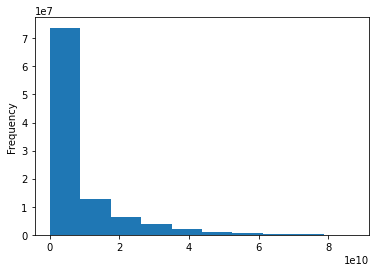

In [8]:
train.timestamp.plot(kind="hist")

In [9]:
train.content_id.value_counts()

6116     213605
6173     202106
4120     199372
175      195861
7876     190170
          ...  
10006         1
10007         1
10008         1
1484          1
21169         1
Name: content_id, Length: 13782, dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   row_id                          uint32
 1   timestamp                       uint64
 2   user_id                         uint32
 3   content_id                      uint16
 4   content_type_id                 uint8 
 5   task_container_id               uint16
 6   user_answer                     int8  
 7   answered_correctly              int8  
 8   prior_question_elapsed_time     uint32
 9   prior_question_had_explanation  object
dtypes: int8(2), object(1), uint16(2), uint32(3), uint64(1), uint8(1)
memory usage: 3.3+ GB


In [11]:
# null value in prior_question_had_explanation_only, but other variables include -1 as missing value
train.isnull().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation    392506
dtype: int64

# lecture
- lectures.csv: metadata for the lectures watched by users as they progress in their education.
- lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
- part: top level category code for the lecture.
- tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- type_of: brief description of the core purpose of the lecture

In [12]:
lectures.shape

(418, 4)

In [13]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [14]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [15]:
lectures.tag.value_counts() # 一部タグに重複あり

136    7
116    6
134    6
27     6
161    6
      ..
99     1
57     1
90     1
83     1
187    1
Name: tag, Length: 151, dtype: int64

In [16]:
lectures.part.value_counts() # 一部タグに重複あり

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [17]:
lectures.type_of.value_counts() # 一部タグに重複あり

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [18]:
lectures.isnull().sum() # no missing value

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

# questions
- questions.csv: metadata for the questions posed to users.
- question_id: foreign key for the train/test content_id column, when the content type is question (0).
- bundle_id: code for which questions are served together.
- correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
- part: the relevant section of the TOEIC test.
- tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [19]:
questions.shape

(13523, 5)

In [20]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [21]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [22]:
len(questions.question_id.unique()) # question_id is unique

13523

In [23]:
len(questions.bundle_id.unique()) # question_id is not unique

9765

In [24]:
questions.part.value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

In [25]:
questions.isnull().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

# combi of question and lecture

In [26]:
# https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns
# https://stackoverflow.com/questions/16228248/how-can-i-get-list-of-values-from-dict
def calc(tags):
    type_count = {'concept':0, 'solving question': 0, 'intention': 0, 'starter':0}
    try:
        tag_list = tags.split(" ")
        type_list = list(lectures[lectures.tag.isin(tag_list)]["type_of"])
    except:
        ans = list(type_count.values())
        return ans[0], ans[1], ans[2], ans[3] 
    for ele in type_list:
        type_count[ele] += 1
    ans = list(type_count.values())
    print(tag_list, type_list ,ans)
    return ans[0], ans[1], ans[2], ans[3] 
questions['concept'], questions['solving question'], questions['intention'], questions['starter'] = zip(*questions['tags'].map(calc))
#questions.apply(lambda x: calc(x), axis=1)

['51', '131', '162', '38'] ['concept', 'solving question'] [1, 1, 0, 0]
['131', '36', '81'] ['solving question', 'solving question', 'concept', 'solving question'] [1, 3, 0, 0]
['131', '101', '162', '92'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['131', '149', '162', '29'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['131', '5', '162', '38'] ['concept', 'solving question'] [1, 1, 0, 0]
['131', '149', '162', '81'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['10', '94', '162', '92'] ['solving question', 'concept', 'solving question', 'solving question', 'solving question'] [1, 4, 0, 0]
['61', '110', '162', '29'] ['solving question', 'solving question', 'solving question', 'concept'] [1, 3, 0, 0]
['131', '13', '162', '92'] ['solving question', 'solving question', 'concept'] [1, 2, 0, 0]
['10', '164', '81'] ['solving question', 'concept'] [1, 1, 0, 0]
['131', '36',

In [27]:
lectures[lectures.tag.isin([131])]

,lecture_id,tag,part,type_of


In [28]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags,concept,solving question,intention,starter
0,0,0,0,1,51 131 162 38,1,1,0,0
1,1,1,1,1,131 36 81,1,3,0,0
2,2,2,0,1,131 101 162 92,1,3,0,0
3,3,3,0,1,131 149 162 29,1,3,0,0
4,4,4,3,1,131 5 162 38,1,1,0,0


- questionとlectureのタグは意味が違うっぽい..

# example_test
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [29]:
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
